# Reviews classification

#### Data loading

* business.json is 153 MB and it will be loaded entirely;
* review.json is 6.3 GB and only first 500.000 records will be loaded.

In [1]:
import json 
import numpy as np
import pandas as pd

In [2]:
data_size_review = 500000

with open('yelp_dataset/yelp_academic_dataset_business.json', 'rb') as f:
    data = f.readlines()

data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

business_df = pd.read_json(data_json_str)

with open("yelp_dataset/yelp_academic_dataset_review.json", 'r') as f:
    review_head = [next(f) for x in range(data_size_review)]
f.close()

review_data = []
for line in review_head:
    review_data.append(json.loads(line))

review_df = pd.DataFrame(review_data)

df = review_df.join(business_df, lsuffix='_r', rsuffix='_b')

print("%i records loaded from business.json, each composed by %i columns." % (business_df.shape[0], business_df.shape[1]))
print("%i records loaded from review.json, each composed by %i columns." % (review_df.shape[0], review_df.shape[1]))
print("%i record produced after joining data, each composed by %i columns." % (df.shape[0], df.shape[1]))

209393 records loaded from business.json, each composed by 14 columns.
500000 records loaded from review.json, each composed by 9 columns.
500000 record produced after joining data, each composed by 23 columns.


#### Data preview

In [3]:
df.head()

,business_id_r,cool,date,funny,review_id,stars_r,text,useful,user_id,address,...,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars_b,state
0,-MhfebM0QIsKt87iDN-FNw,0,2015-04-15 05:21:16,0,xQY8N_XvtGbearJ5X4QryQ,2.0,"As someone who has worked with many museums, I...",5,OwjRMXRC0KyPrIlcjaXeFQ,10913 Bailey Rd,...,Cornelius,"{u'Monday': u'10:0-18:0', u'Tuesday': u'11:0-2...",1.0,35.462724,-80.852612,The Range At Lake Norman,28031,36.0,3.5,NC
1,lbrU8StCq3yDfr-QMnGrmQ,0,2013-12-07 03:16:52,1,UmFMZ8PyXZTY2QcwzsfQYA,1.0,I am actually horrified this place is still in...,1,nIJD_7ZXHq-FX8byPMOkMQ,"8880 E Via Linda, Ste 107",...,Scottsdale,None,1.0,33.569404,-111.890264,"Carlos Santo, NMD",85258,4.0,5.0,AZ
2,HQl28KMwrEKHqhFrrDqVNQ,0,2015-12-05 03:18:11,0,LG2ZaYiOgpr2DK_90pYjNw,5.0,I love Deagan's. I do. I really do. The atmosp...,1,V34qejxNsCbcgD8C0HVk-Q,3554 Rue Notre-Dame O,...,Montreal,None,1.0,45.479984,-73.580070,Felinus,H4C 1P4,5.0,5.0,QC
3,5JxlZaqCnk1MnbgRirs40Q,0,2011-05-27 05:30:52,0,i6g_oA9Yf9Y31qt0wibXpw,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0,ofKDkJKXSKZXu5xJNGiiBQ,1015 Sharp Cir,...,North Las Vegas,"{u'Friday': u'7:0-16:0', u'Tuesday': u'7:0-16:...",0.0,36.219728,-115.127725,Nevada House of Hose,89030,3.0,2.5,NV
4,IS4cv902ykd8wj1TR0N3-A,0,2017-01-14 21:56:57,0,6TdNDKywdbjoTkizeMce8A,4.0,"Oh happy day, finally have a Canes near my cas...",0,UgMW8bLE0QMJDCkQ1Ax5Mg,4827 E Downing Cir,...,Mesa,"{u'Friday': u'9:0-16:0', u'Tuesday': u'9:0-16:...",1.0,33.428065,-111.726648,USE MY GUY SERVICES LLC,85205,26.0,4.5,AZ


#### Building the prediction model

We want to build a deep neural network that can rate from 1 to 5 a review given in input. The model will be trained on the review data from Yelp Dataset, in which each review is associated to a star rank from 1 (bad) to 5 (good).

In [4]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [125]:
# to train the model we need (input, output) pairs: 
# sentences is the array of inputs and labels is the array of outputs.
sentences = []
for text in df.text:
    sentences.append(text)
    
labels = []
for star in df.stars_r:
    labels.append(star)
    
print(len(sentences), len(labels))

(500000, 500000)


In [126]:
size = 50000
train_size = int(size*0.9)
print(size, train_size)

(50000, 45000)


In [127]:
sentences = sentences[:size]
labels = labels[:size]

print(len(sentences), len(labels))

# split the data in (train_data, test_data)
train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]

# it's better to normalize output values to have them between 0 and 1
train_labels = np.array(labels[:train_size])/5
test_labels = np.array(labels[train_size:])/5

print(np.shape(train_sentences), np.shape(test_sentences))
print(np.shape(train_labels), np.shape(test_labels))

(50000, 50000)
((45000,), (5000,))
((45000,), (5000,))


In [128]:
vocab_size = 10000
embedding_dim = 64
max_length = 500

In [129]:
# tokenization phase, may takes few minutes

tokenizer = Tokenizer(num_words=vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(train_sentences)
    
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post')

print(np.shape(train_padded))
print(np.shape(test_padded))

(45000, 500)
(5000, 500)


In [130]:
# compose the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.save_weights('my_model_weights.h5')

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_28 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

In [131]:
# train the model

epochs = [10,20,30]
history = []

for ep in epochs:
    model.load_weights('my_model_weights.h5')
    history.append(model.fit(np.array(train_padded), np.array(train_labels), epochs=ep,
                       validation_data=(test_padded, test_labels), verbose=2))

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 - 21s - loss: 0.6032 - accuracy: 0.4382 - val_loss: 0.5618 - val_accuracy: 0.4448
Epoch 2/10
45000/45000 - 18s - loss: 0.5634 - accuracy: 0.4385 - val_loss: 0.5571 - val_accuracy: 0.4448
Epoch 3/10
45000/45000 - 18s - loss: 0.5627 - accuracy: 0.4385 - val_loss: 0.5571 - val_accuracy: 0.4448
Epoch 4/10
45000/45000 - 18s - loss: 0.5627 - accuracy: 0.4385 - val_loss: 0.5571 - val_accuracy: 0.4448
Epoch 5/10
45000/45000 - 18s - loss: 0.5627 - accuracy: 0.4385 - val_loss: 0.5571 - val_accuracy: 0.4448
Epoch 6/10
45000/45000 - 18s - loss: 0.5627 - accuracy: 0.4385 - val_loss: 0.5571 - val_accuracy: 0.4448
Epoch 7/10
45000/45000 - 18s - loss: 0.5627 - accuracy: 0.4385 - val_loss: 0.5571 - val_accuracy: 0.4448
Epoch 8/10
45000/45000 - 18s - loss: 0.5627 - accuracy: 0.4385 - val_loss: 0.5571 - val_accuracy: 0.4448
Epoch 9/10
45000/45000 - 18s - loss: 0.5627 - accuracy: 0.4385 - val_loss: 0.5570 - val_accuracy: 0.4448
Epoch 

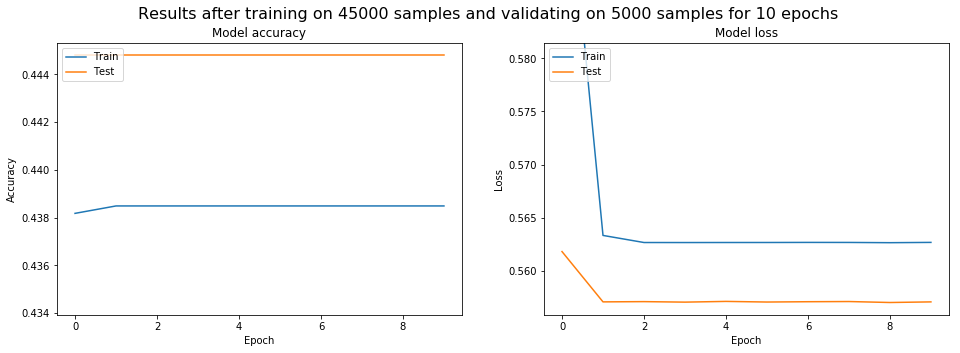

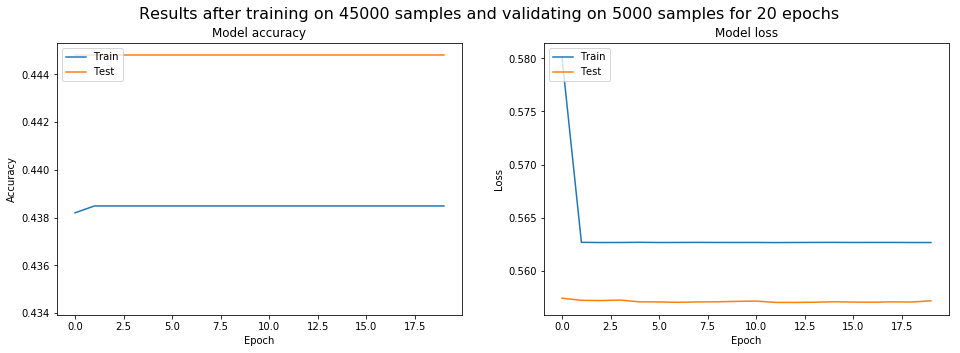

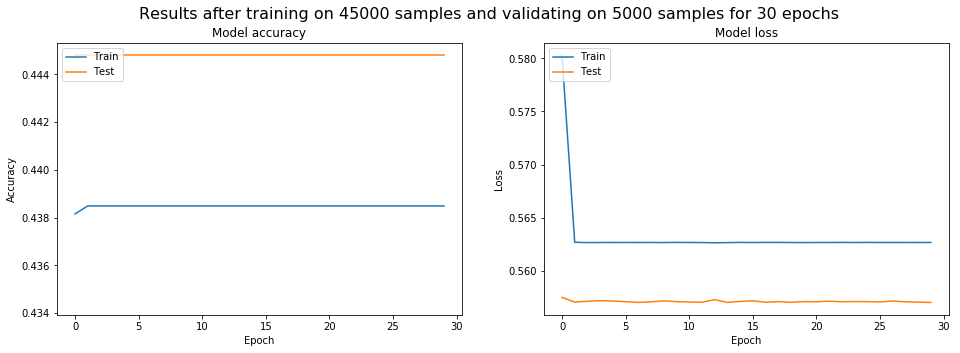

In [132]:
# print results

import matplotlib.pyplot as plt

min_accuracy = min([el for el in hist.history['accuracy'] for hist in history] + 
                  [el for el in hist.history['val_accuracy'] for hist in history])
max_accuracy = max([el for el in hist.history['accuracy'] for hist in history] + 
                  [el for el in hist.history['val_accuracy'] for hist in history])
padding_accuracy = (max_accuracy-min_accuracy)*0.05
min_loss = min([el for el in hist.history['loss'] for hist in history] + 
                  [el for el in hist.history['val_loss'] for hist in history])
max_loss = max([el for el in hist.history['loss'] for hist in history] + 
                  [el for el in hist.history['val_loss'] for hist in history])
padding_loss = (max_loss-min_loss)*0.05


for i in range(len(history)):

    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle('Results after training on %i samples and validating on %i samples for %i epochs' 
                 % (train_size, size-train_size, epochs[i]), fontsize=16)

    # summarize history for accuracy
    axes[0].plot(history[i].history['accuracy'])
    axes[0].plot(history[i].history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim([min_accuracy-padding_accuracy, max_accuracy+padding_accuracy])
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='upper left')

    # summarize history for loss
    axes[1].plot(history[i].history['loss'])
    axes[1].plot(history[i].history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_ylim([min_loss-padding_loss, max_loss+padding_loss])
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [124]:
# make prediction

sentences = [
    "Horrible, this is a bad place. Disgusting",
    "I recommed to all to have a dinner here!"
]

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

result = model.predict(padded)

for i in range(len(result)):
    print('"%s" rating prediction is %i stars.' % (sentences[i], round(result[i]*5)))

"Horrible, this is a bad place. Disgusting" rating prediction is 1 stars.
"I recommed to all to have a dinner here!" rating prediction is 3 stars.
